In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
  import numpy as np
  import tensorflow as tf
  from tensorflow import keras
  from tensorflow.keras import applications
  from tensorflow.keras.applications import ResNet50
  from tensorflow.keras.models import Sequential, Model
  from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, Input, AveragePooling2D 
  from tensorflow.keras.optimizers import Adam
  from tensorflow.keras.metrics import categorical_crossentropy
  from tensorflow.keras.preprocessing.image import  ImageDataGenerator
  from sklearn.metrics import confusion_matrix
  import itertools
  import os
  import cv2
  import shutil
  import random
  import glob
  import matplotlib.pyplot as plt
  import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
%matplotlib inline

In [3]:
train_path = '/content/drive/MyDrive/SignatureAuthentication/Train'
valid_path = '/content/drive/MyDrive/SignatureAuthentication/Valid'
test_path = '/content/drive/MyDrive/SignatureAuthentication/Test'

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(directory=train_path, target_size=(224, 224), classes=['forgeries', 'genuines'], batch_size=7)

valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(directory=valid_path, target_size=(224, 224), classes=['forgeries', 'genuines'], batch_size=8)

test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input)\
.flow_from_directory(directory=test_path, target_size=(224, 224), classes=['forgeries', 'genuines'], batch_size=7, shuffle=False)

Found 1106 images belonging to 2 classes.
Found 312 images belonging to 2 classes.
Found 156 images belonging to 2 classes.


In [4]:
assert train_batches.n == 1106
assert valid_batches.n == 312
assert test_batches.n == 156
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

In [5]:
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

94781440/94765736 [==============================] - 1s 0us/step


In [6]:
baseModel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [7]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(units=2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [9]:
for layer in baseModel.layers:
	layer.trainable = False

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
history = model.fit(x=train_batches, validation_data=valid_batches, epochs=20, steps_per_epoch= 158, validation_steps=39)
model.save('/content/drive/MyDrive/Project/Resnet50_SignatureDetection_N.h5')

Epoch 1/20
158/158 [==============================] - 473s 3s/step - loss: 0.8050 - accuracy: 0.6166 - val_loss: 0.5104 - val_accuracy: 0.7692
Epoch 2/20
158/158 [==============================] - 229s 1s/step - loss: 0.6021 - accuracy: 0.6926 - val_loss: 0.5574 - val_accuracy: 0.6891
Epoch 3/20
158/158 [==============================] - 229s 1s/step - loss: 0.5317 - accuracy: 0.7297 - val_loss: 0.4544 - val_accuracy: 0.8077
Epoch 4/20
158/158 [==============================] - 229s 1s/step - loss: 0.4716 - accuracy: 0.7613 - val_loss: 0.4595 - val_accuracy: 0.7724
Epoch 5/20
158/158 [==============================] - 229s 1s/step - loss: 0.4252 - accuracy: 0.7993 - val_loss: 0.4000 - val_accuracy: 0.8333
Epoch 6/20
158/158 [==============================] - 228s 1s/step - loss: 0.4083 - accuracy: 0.8174 - val_loss: 0.3997 - val_accuracy: 0.8237
Epoch 7/20
158/158 [==============================] - 229s 1s/step - loss: 0.3830 - accuracy: 0.8282 - val_loss: 0.3892 - val_accuracy: 0.8301

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


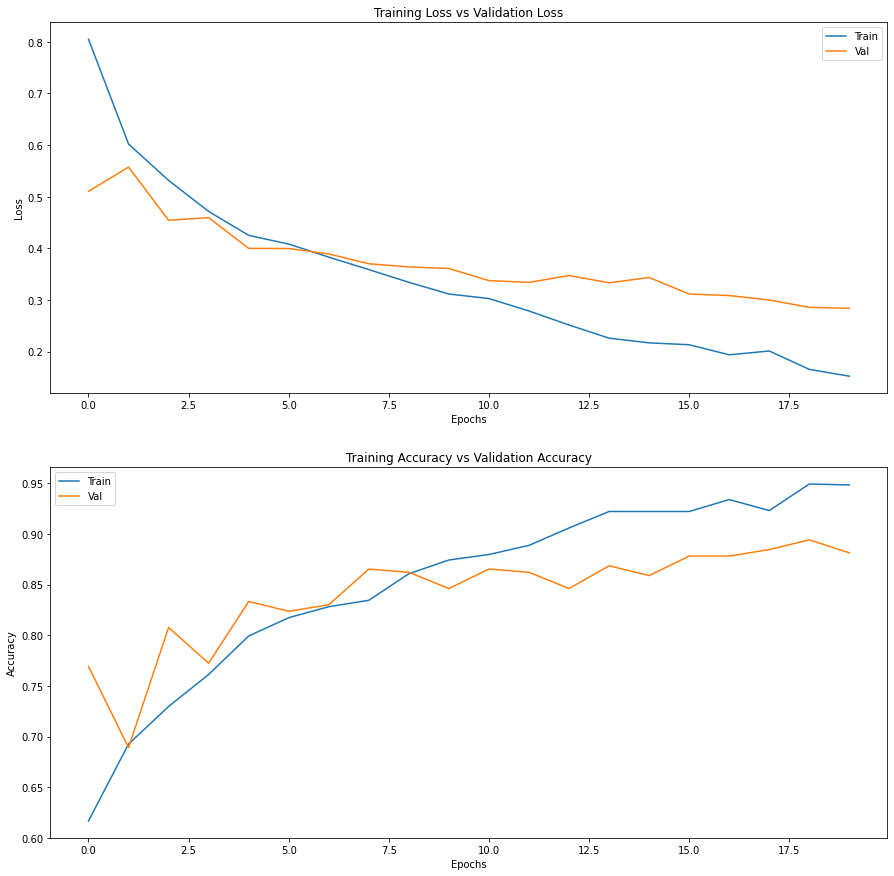

In [13]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

In [5]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int32)

In [6]:
# MyModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# MyModel.load_weights('/content/drive/MyDrive/SignatureAuthentication/TrainedWeights/Resnet50_SignatureDetection_N.h5')
MyModel = tf.keras.models.load_model('/content/drive/MyDrive/SignatureAuthentication/TrainedWeights/Resnet50_SignatureDetection_N.h5')

loss, acc = MyModel.evaluate(test_batches, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

23/23 - 67s - loss: 0.2402 - accuracy: 0.9038 - 67s/epoch - 3s/step
Restored model, accuracy: 90.38%


In [7]:
predictions = MyModel.predict(x = test_batches, verbose = 2)

23/23 - 23s - 23s/epoch - 992ms/step


In [8]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

In [10]:
test_batches.class_indices

{'forgeries': 0, 'genuines': 1}

Confusion matrix, without normalization
[[55  7]
 [ 8 86]]


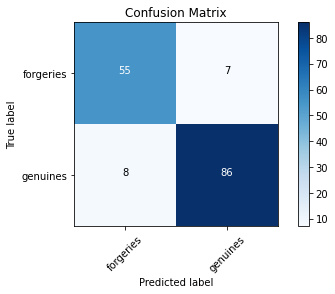

In [11]:
cm_plot_labels = ['forgeries', 'genuines']
plot_confusion_matrix(cm=cm, classes = cm_plot_labels, title = 'Confusion Matrix')